# Import packages

In [1]:
import numpy as np
import pandas as pd
import patsy.version
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import math
import patsy 
from causalml.dataset.regression import *
from causalml.metrics import *
import scipy
import random
import tensorflow as tf

c:\Users\ASUS\anaconda3\envs\causalml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


# DragonNet model(modified)

In [2]:
#https://github.com/uber/causalml/blob/master/causalml/inference/tf/dragonnet.py
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from causalml.inference.tf.utils import (
    dragonnet_loss_binarycross,
    EpsilonLayer,
    regression_loss,
    binary_classification_loss,
    treatment_accuracy,
    track_epsilon,
    make_tarreg_loss,
)
from causalml.inference.meta.utils import convert_pd_to_np

class DragonNet:
    def __init__(
        self,
        neurons_per_layer=200,
        targeted_reg=True,
        ratio=1.0,
        val_split=0.2,
        batch_size=64,
        epochs=100,
        learning_rate=1e-5,
        momentum=0.9,
        reg_l2=0.01,
        use_adam=True,
        adam_epochs=30,
        adam_learning_rate=1e-3,
        loss_func=dragonnet_loss_binarycross,
        verbose=True,
    ):
        """
        Initializes a Dragonnet.
        """
        self.neurons_per_layer = neurons_per_layer
        self.targeted_reg = targeted_reg
        self.ratio = ratio
        self.val_split = val_split
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.use_adam = use_adam
        self.adam_learning_rate = adam_learning_rate
        self.adam_epochs = adam_epochs
        self.reg_l2 = reg_l2
        self.loss_func = loss_func
        self.verbose = verbose

    def make_dragonnet(self, input_dim):
        """
        Neural net predictive model. The dragon has three heads.

        Args:
            input_dim (int): number of rows in input
        Returns:
            model (keras.models.Model): DragonNet model
        """
        inputs = Input(shape=(input_dim,), name="input")

        # representation
        x = Dense(
            units=self.neurons_per_layer,
            activation="elu",
            kernel_initializer="RandomNormal",
        )(inputs)
        x = Dense(
            units=self.neurons_per_layer,
            activation="elu",
            kernel_initializer="RandomNormal",
        )(x)
        x = Dense(
            units=self.neurons_per_layer,
            activation="elu",
            kernel_initializer="RandomNormal",
        )(x)

        t_predictions = Dense(units=1, activation="sigmoid")(x)

        # HYPOTHESIS
        y0_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(x)
        y1_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(x)

        # second layer
        y0_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(y0_hidden)
        y1_hidden = Dense(
            units=int(self.neurons_per_layer / 2),
            activation="elu",
            kernel_regularizer=l2(self.reg_l2),
        )(y1_hidden)

        # third
        y0_predictions = Dense(
            units=1,
            activation="sigmoid",
            kernel_regularizer=l2(self.reg_l2),
            name="y0_predictions",
        )(y0_hidden)
        y1_predictions = Dense(
            units=1,
            activation="sigmoid",
            kernel_regularizer=l2(self.reg_l2),
            name="y1_predictions",
        )(y1_hidden)

        dl = EpsilonLayer()
        epsilons = dl(t_predictions, name="epsilon")
        concat_pred = Concatenate(1)(
            [y0_predictions, y1_predictions, t_predictions, epsilons]
        )
        model = Model(inputs=inputs, outputs=concat_pred)

        return model

    def fit(self, X, treatment, y, p=None):
        """
        Fits the DragonNet model.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        y = np.hstack((y.reshape(-1, 1), treatment.reshape(-1, 1)))

        self.dragonnet = self.make_dragonnet(X.shape[1])

        metrics = [
            regression_loss,
            binary_classification_loss,
            treatment_accuracy,
            track_epsilon,
        ]

        if self.targeted_reg:
            loss = make_tarreg_loss(ratio=self.ratio, dragonnet_loss=self.loss_func)
        else:
            loss = self.loss_func

        if self.use_adam:
            self.dragonnet.compile(
                optimizer=Adam(learning_rate=self.adam_learning_rate),
                loss=loss,
                metrics=metrics,
            )

            adam_callbacks = [
                TerminateOnNaN(),
                EarlyStopping(monitor="val_loss", patience=2, min_delta=0.0),
                ReduceLROnPlateau(
                    monitor="loss",
                    factor=0.5,
                    patience=5,
                    verbose=self.verbose,
                    mode="auto",
                    min_delta=1e-8,
                    cooldown=0,
                    min_lr=0,
                ),
            ]

            self.dragonnet.fit(
                X,
                y,
                callbacks=adam_callbacks,
                validation_split=self.val_split,
                epochs=self.adam_epochs,
                batch_size=self.batch_size,
                verbose=self.verbose,
            )

        sgd_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor="val_loss", patience=40, min_delta=0.0),
            ReduceLROnPlateau(
                monitor="loss",
                factor=0.5,
                patience=5,
                verbose=self.verbose,
                mode="auto",
                min_delta=0.0,
                cooldown=0,
                min_lr=0,
            ),
        ]

        self.dragonnet.compile(
            optimizer=SGD(
                learning_rate=self.learning_rate, momentum=self.momentum, nesterov=True
            ),
            loss=loss,
            metrics=metrics,
        )
        self.dragonnet.fit(
            X,
            y,
            callbacks=sgd_callbacks,
            validation_split=self.val_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
        )

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.array): a 2D array with shape (X.shape[0], 4),
                where each row takes the form of (outcome do(t=0), outcome do(t=1), propensity, epsilon)
        """
        return self.dragonnet.predict(X)

    def predict_propensity(self, X):
        """
        Predicts the individual propensity scores.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.array): propensity score vector
        """
        preds = self.predict(X)
        return preds[:, 2]

    def predict_tau(self, X):
        """
        Predicts the individual treatment effect (tau / "ITE").

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.array): treatment effect vector
        """
        preds = self.predict(X)
        return (preds[:, 1] - preds[:, 0]).reshape(-1, 1)

    def fit_predict(self, X, treatment, y, p=None, return_components=False):
        """
        Fits the DragonNet model and then predicts.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            return_components (bool, optional): whether to return
        Returns:
            (np.array): predictions based on return_components flag
                if return_components=False (default), each row is treatment effect
                if return_components=True, each row is (outcome do(t=0), outcome do(t=1), propensity, epsilon)
        """
        self.fit(X, treatment, y)
        return self.predict_tau(X)

    def save(self, h5_filepath):
        """
        Save the dragonnet model as a H5 file.

        Args:
            h5_filepath (H5 file path): H5 file path
        """
        self.dragonnet.save(h5_filepath)

    def load(self, h5_filepath, ratio=1.0, dragonnet_loss=dragonnet_loss_binarycross):
        """
        Load the dragonnet model from a H5 file.

        Args:
            h5_filepath (H5 file path): H5 file path
            ratio (float): weight assigned to the targeted regularization loss component
            dragonnet_loss (function): a loss function
        """
        self.dragonnet = load_model(
            h5_filepath,
            custom_objects={
                "EpsilonLayer": EpsilonLayer,
                "dragonnet_loss_binarycross": dragonnet_loss_binarycross,
                "tarreg_ATE_unbounded_domain_loss": make_tarreg_loss(
                    ratio=ratio, dragonnet_loss=dragonnet_loss
                ),
                "regression_loss": regression_loss,
                "binary_classification_loss": binary_classification_loss,
                "treatment_accuracy": treatment_accuracy,
                "track_epsilon": track_epsilon,
            },
        )

# Import data

In [3]:
data = pd.read_csv("C:/Users/ASUS/Desktop/cg working/CausalML/simulation data_DTR/for plan/simulation data(binary).csv")
data_train, data_test=train_test_split(data,test_size=0.2,random_state=91626)
data_train

,id,bloc,true_ite.(Death),Death,Treat,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
6472,6473,0,0.682902,0,0,0,0.254906,0.944751,-0.074629,3.269318,-0.665121,1.202297,-0.828230,0.621825,0.009106
3205,3206,0,0.013532,0,1,1,0.218906,-3.408251,0.368003,0.363680,1.160311,-0.020015,0.507427,2.545446,0.870314
6450,6451,0,0.609789,0,0,0,0.575765,1.620563,-2.195253,-0.449026,0.446350,-1.049989,1.228228,1.017968,-1.040547
1456,1457,0,0.639684,1,1,0,0.443885,0.959867,0.328732,0.750321,-1.653634,-1.825425,-2.144697,0.071179,2.517118
4083,4084,0,0.396884,1,0,0,-0.220555,0.331547,1.500219,-0.189197,0.337513,0.983597,1.151011,-0.790246,-1.424898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,4183,0,0.324620,0,0,0,1.112723,0.128331,-0.828687,-0.745687,-1.491760,-0.843627,-0.893345,-0.229870,1.381539
5082,5083,0,0.173720,1,0,1,-0.096516,-0.372164,-0.962702,-0.070504,-0.627134,-0.815309,0.939247,0.523982,-1.652024
3379,3380,0,0.394005,1,1,1,1.618848,0.171271,0.891289,-0.242350,-0.449774,1.096188,0.589630,-1.907868,-0.284011
6824,6825,0,0.073421,0,1,1,-0.104243,-0.991804,-1.424458,-0.186849,0.471382,-0.218532,-0.975700,1.470087,-0.669636


In [4]:
data3_train=data_train.drop(columns=["bloc","id","true_ite.(Death)"])
data3_test=data_test
data3_train=data3_train.reset_index(drop=True)
data3_test=data3_test.reset_index(drop=True)

n=data3_train.shape[0]
p=data3_train.shape[1]-2
sqrt_p=math.floor(p**0.5)
dv3_p=math.floor(p/3)
view={"":["training set","testing set"],
      "Death_prop":[sum(data3_train["Death"])/n,sum(data3_test["Death"])/n*4],
      "Treat_prop":[sum(data3_train["Treat"])/n,sum(data3_test["Treat"])/n*4]}
view=pd.DataFrame(view)
view

,,Death_prop,Treat_prop
0,training set,0.363,0.460000
1,testing set,0.382,0.458667


# --------------------DoubleML (IRM)--------------------

In [5]:
#analysis3_2
RFr_g=RandomForestClassifier(n_estimators=500,max_features=sqrt_p,max_depth=None)
RFr_m=RandomForestClassifier(n_estimators=500,max_features=sqrt_p,max_depth=None)
obj_data3=dml.DoubleMLData(data3_train,"Death","Treat")
np.random.seed(62619)
dml_irm_obj=dml.DoubleMLIRM(obj_data3,RFr_g,RFr_m)
result3_2=dml_irm_obj.fit(store_predictions=True)
a3_2=result3_2.nuisance_loss["ml_g1"][0]
aa3_2=result3_2.nuisance_loss["ml_g0"][0]
b3_2=result3_2.nuisance_loss["ml_m"][0]
c3_2=result3_2.coef

residm3_2=list(range(n))
residm3_2sq=list(range(n))
for i in range(n):
    def dblresid(y_true,y_pred):
        ans=y_true[0,i]-y_pred[0,i]
        return ans
    residm=dml_irm_obj.evaluate_learners(learners=["ml_m"],metric=dblresid)
    residm3_2[i]=residm["ml_m"][0]
    residm3_2sq[i]=residm["ml_m"][0]**2

predg3_2=list(range(n))
for i in range(n):
    def dblpred(y_true,y_pred):
        ans=y_pred[0,i]
        return ans
    predm=dml_irm_obj.evaluate_learners(learners=["ml_g1"],metric=dblpred)
    predg3_2[i]=predm["ml_g1"][0]

predgg3_2=list(range(n))
for i in range(n):
    def dblpred(y_true,y_pred):
        ans=y_pred[0,i]
        return ans
    predm=dml_irm_obj.evaluate_learners(learners=["ml_g0"],metric=dblpred)
    predgg3_2[i]=predm["ml_g0"][0]

pred3_2_1=pd.DataFrame({"pred3_2":[0]*n})
pred3_2_0=pd.DataFrame({"pred3_2":[0]*n})
pred3_2prob1=pd.DataFrame(np.array(predg3_2))
pred3_2prob1.columns=list("p")
pred3_2prob0=pd.DataFrame(np.array(predgg3_2))
pred3_2prob0.columns=list("p")
pred3_2_1[pred3_2prob1["p"]>0.5]=1
pred3_2_0[pred3_2prob0["p"]>0.5]=1
pred3_2_1loglossb=log_loss(data3_train["Death"][data3_train["Treat"]==1],pred3_2prob1["p"][np.array(data3_train["Treat"]==1)])
pred3_2_0loglossb=log_loss(data3_train["Death"][data3_train["Treat"]==0],pred3_2prob0["p"][np.array(data3_train["Treat"]==0)])

result3_2_1RMSE=(np.array(data3_train["Death"])-np.array(pred3_2prob1["p"]))**2
result3_2_1RMSE=sum(result3_2_1RMSE[data3_train["Treat"]==1])/len(result3_2_1RMSE[data3_train["Treat"]==1])
result3_2_1RMSE=result3_2_1RMSE**0.5
result3_2_0RMSE=(np.array(data3_train["Death"])-np.array(pred3_2prob0["p"]))**2
result3_2_0RMSE=sum(result3_2_0RMSE[data3_train["Treat"]==0])/len(result3_2_0RMSE[data3_train["Treat"]==0])
result3_2_0RMSE=result3_2_0RMSE**0.5

pred3_2prob_final=(np.array(data3_train["Treat"])*np.array(pred3_2prob1["p"]))+\
                  ((1-np.array(data3_train["Treat"]))*np.array(pred3_2prob0["p"]))
result3_2_RMSE_final=sum((np.array(data3_train["Death"])-np.array(pred3_2prob_final))**2)/n
result3_2_RMSE_final=result3_2_RMSE_final**0.5
pred3_2_final=(np.array(data3_train["Treat"])*np.array(pred3_2_1["pred3_2"]))+\
              ((1-np.array(data3_train["Treat"]))*np.array(pred3_2_0["pred3_2"]))
result3_2_logloss_final=log_loss(data3_train["Death"],pred3_2prob_final)
accuracy3_2=accuracy_score(data3_train["Death"],pred3_2_final)

temp={"ite":pred3_2prob1["p"]-pred3_2prob0["p"],
       "w":data3_train["Treat"],
       "y":data3_train["Death"]}
iteirm=pd.DataFrame(temp)
AUUCirm=auuc_score(iteirm)

# CATE

        0         1         2         3         4         5
0     1.0  0.000000  0.187211  0.783244  0.029545  0.000000
1     1.0  0.000000  0.221085  0.756810  0.022105  0.000000
2     1.0  0.000000  0.009663  0.846899  0.143439  0.000000
3     1.0  0.000000  0.055571  0.858160  0.086269  0.000000
4     1.0  0.016812  0.749043  0.234145  0.000000  0.000000
...   ...       ...       ...       ...       ...       ...
5995  1.0  0.000000  0.000000  0.575457  0.400377  0.024167
5996  1.0  0.002772  0.619718  0.377511  0.000000  0.000000
5997  1.0  0.000000  0.000000  0.358712  0.530259  0.111029
5998  1.0  0.003300  0.629115  0.367585  0.000000  0.000000
5999  1.0  0.248883  0.748729  0.000000  0.000000  0.000000

[6000 rows x 6 columns]
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t     P>|t|    [0.025    0.975]
0 -0.415877  0.296338 -1.403389  0.160553 -0.996806  0.165051
1  0.492325  0.373613  

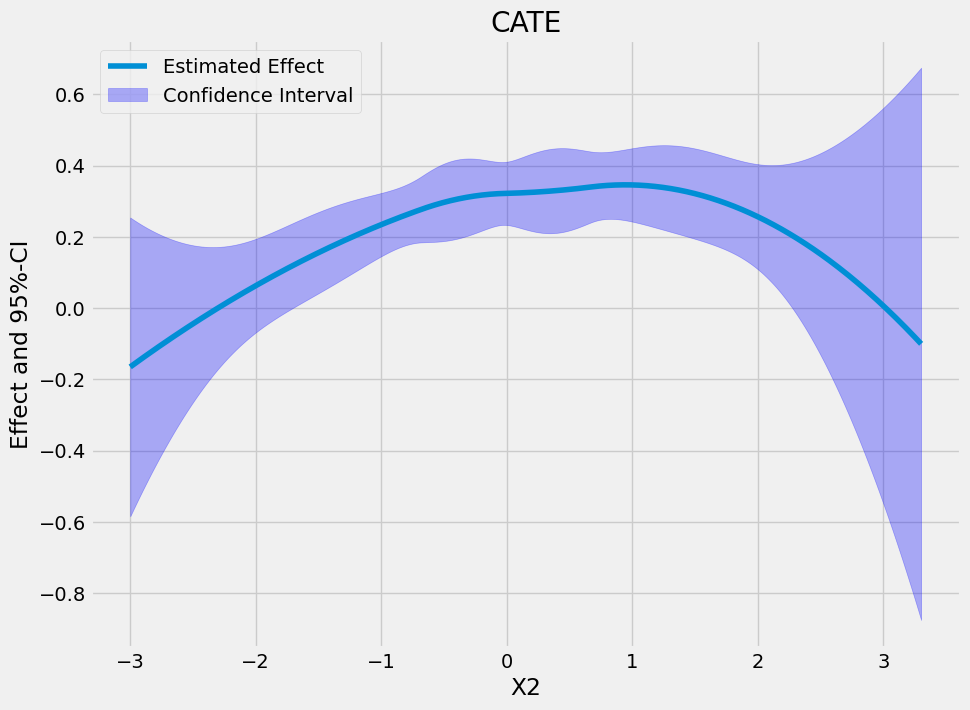

In [6]:
#cate3-2------------------------------------------------------------------------------------------------------------
design_matrix = patsy.dmatrix("bs(X2, df=5, degree=2)", {"X2": data3_train["X2"]})
spline_basis = pd.DataFrame(design_matrix)
print(spline_basis)
cate = dml_irm_obj.cate(spline_basis)
print(cate)

new_data = {"X2": np.linspace(-3, 3.3, 500)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
np.random.seed(1212)
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=5000)

#plot cate3-2
plt.rcParams['figure.figsize'] = 10.0, 7.5
df_cate['X2'] = new_data['X2']
fig, ax = plt.subplots()
ax.plot(df_cate['X2'],df_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['X2'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

#CATE naive
iteirm_X={"X2":data3_train["X2"],
          "ITE":iteirm["ite"],
          "CATE":[0]*n}
iteirm_X=pd.DataFrame(iteirm_X)
iteirm_X=iteirm_X.sort_values(by="X2")
iteirm_X=iteirm_X.reset_index(drop=True)

ans=[]
for i in list(dict.fromkeys(iteirm_X["X2"])):
    tt=iteirm_X[iteirm_X["X2"]==i]
    mean=np.average(tt["ITE"])
    ans=ans+[mean]*tt.shape[0]

XX=[]
YY=[]
for i in list(range(100)):
    a=int(np.floor((n/100)*i))
    b=int(np.floor((n/100)*(i+1))-1)
    tt=iteirm_X.iloc[a:b]
    mean=np.average(tt["ITE"])
    YY=YY+[mean]
    XX=XX+[iteirm_X["X2"][b]]

plt.legend()
plt.title('CATE')
plt.xlabel('X2')
_ =  plt.ylabel('Effect and 95%-CI')
plt.show()

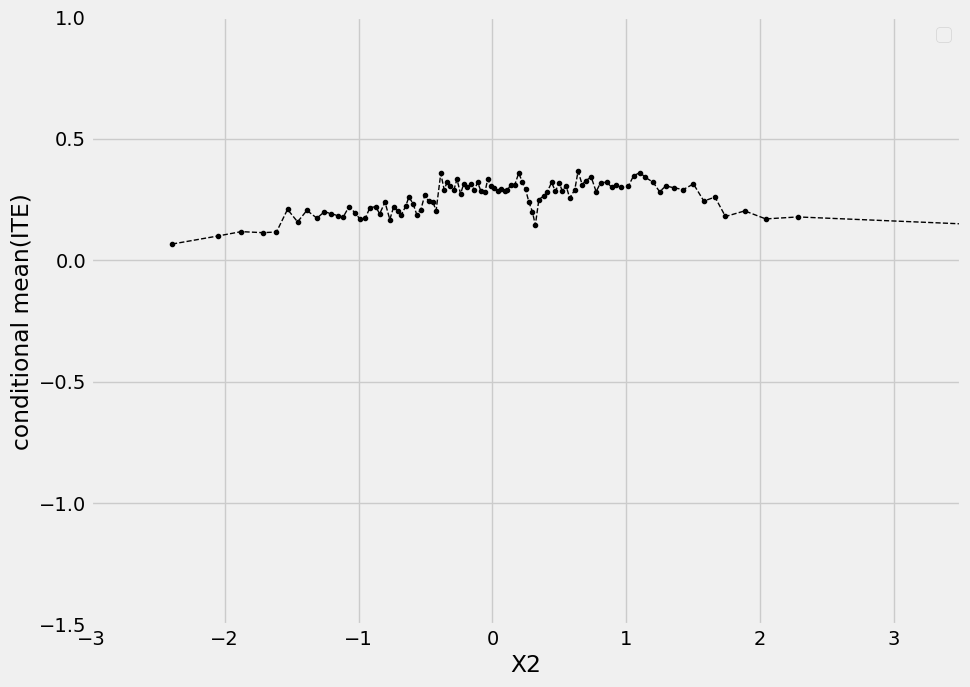

In [7]:
plt.legend()
plt.xlabel('X2')
_ =  plt.ylabel('conditional mean(ITE)')
plt.xlim(-3,3.5)
plt.ylim(-1.5,1)
plt.plot(pd.DataFrame(np.array(XX))[0],pd.DataFrame(np.array(YY))[0],marker=".",color="black",linestyle="--",linewidth=1)
plt.show()

# --------------------DragonNet--------------------

In [15]:
#analysis dragon
data4_train=data_train.drop(columns=["bloc","id","true_ite.(Death)"])
data4_train=data4_train.reset_index(drop=True)
X = data4_train.drop("Death",axis=1)
X = X.drop("Treat",axis=1)
names=X.columns
#Normalization data
scaler=StandardScaler().fit(X)
X=scaler.transform(X)
X=pd.DataFrame(X)
X.columns=names

treatment = data4_train["Treat"]
treatment = treatment.astype("float")
y = data4_train['Death']

def seed_every(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_every(62619)
dragon = DragonNet(neurons_per_layer=8, batch_size=512,epochs=300,adam_epochs=100)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

df_preds = pd.DataFrame([np.array(pred3_2prob1["p"]-pred3_2prob0["p"]),
                         dragon_ite.ravel(),
                         treatment.ravel(),
                         y.ravel()],
                         index=["IRM",'dragonnet','w','y']).T

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - binary_classification_loss: 350.7893 - loss: 603.5001 - regression_loss: 125.9563 - track_epsilon: 0.0566 - treatment_accuracy: 0.5197 - val_binary_classification_loss: 277.0110 - val_loss: 542.3340 - val_regression_loss: 97.5515 - val_track_epsilon: 0.0510 - val_treatment_accuracy: 0.6050 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_classification_loss: 350.4730 - loss: 598.2796 - regression_loss: 123.5152 - track_epsilon: 0.0493 - treatment_accuracy: 0.6069 - val_binary_classification_loss: 276.6147 - val_loss: 536.8056 - val_regression_loss: 95.3207 - val_track_epsilon: 0.0440 - val_treatment_accuracy: 0.6350 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_classification_loss: 349.8592 - loss: 593.5220 - regression_loss: 121.3522 - track_epsilon: 0.0427 - treatment_accuracy: 0.6309 - val_binary_classification_loss: 275.8089 - val_loss: 531.3053 - val_regr

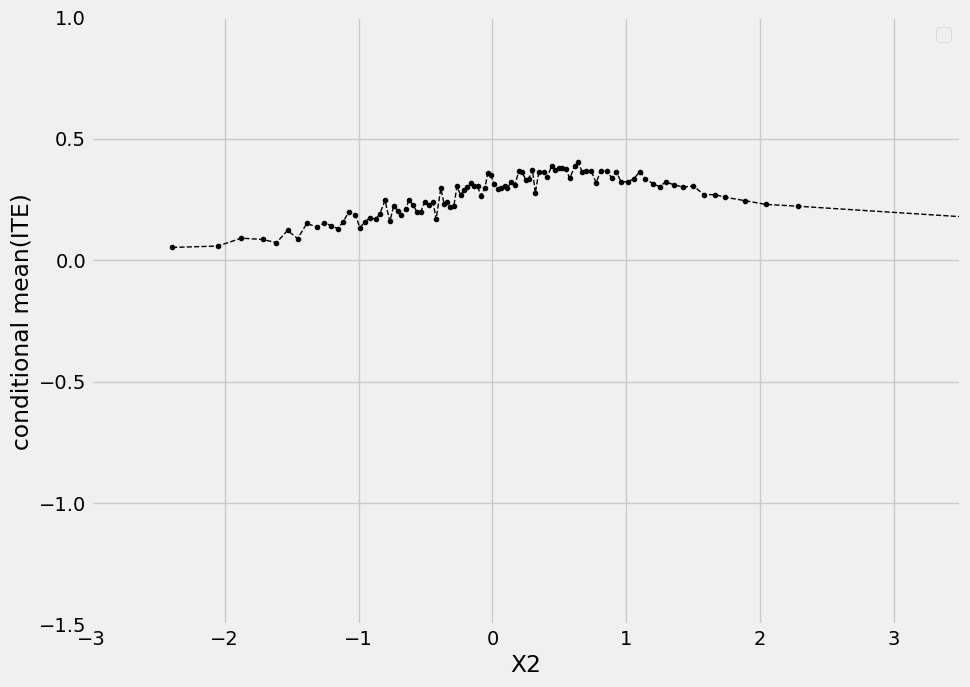

In [16]:
#CATE naive
itedragon_X={"X2":data4_train["X2"],
          "ITE":df_preds["dragonnet"],
          "CATE":[0]*n}
itedragon_X=pd.DataFrame(itedragon_X)
itedragon_X=itedragon_X.sort_values(by="X2")
itedragon_X=itedragon_X.reset_index(drop=True)

ans=[]
for i in list(dict.fromkeys(itedragon_X["X2"])):
    tt=itedragon_X[itedragon_X["X2"]==i]
    mean=np.average(tt["ITE"])
    ans=ans+[mean]*tt.shape[0]
itedragon_X["CATE"]=ans

XX=[]
YY=[]
for i in list(range(100)):
    a=int(np.floor((n/100)*i))
    b=int(np.floor((n/100)*(i+1))-1)
    tt=itedragon_X.iloc[a:b]
    mean=np.average(tt["ITE"])
    YY=YY+[mean]
    XX=XX+[itedragon_X["X2"][b]]


plt.legend()
plt.xlabel('X2')
_ =  plt.ylabel('conditional mean(ITE)')
plt.xlim(-3,3.5)
plt.ylim(-1.5,1)
plt.plot(pd.DataFrame(np.array(XX))[0],pd.DataFrame(np.array(YY))[0],marker=".",color="black",linestyle="--",linewidth=1)
plt.show()

# --------------------Results--------------------

# Uplift curve compare

        IRM  dragonnet    w    y
0     0.328   0.547201  0.0  0.0
1    -0.072  -0.133556  1.0  0.0
2     0.312   0.556560  0.0  0.0
3     0.458   0.553353  1.0  1.0
4     0.154   0.407709  0.0  1.0
...     ...        ...  ...  ...
5995  0.200   0.371414  0.0  0.0
5996  0.038   0.179364  0.0  1.0
5997  0.144   0.312711  1.0  1.0
5998 -0.022   0.036800  1.0  0.0
5999 -0.036  -0.047228  1.0  1.0

[6000 rows x 4 columns]


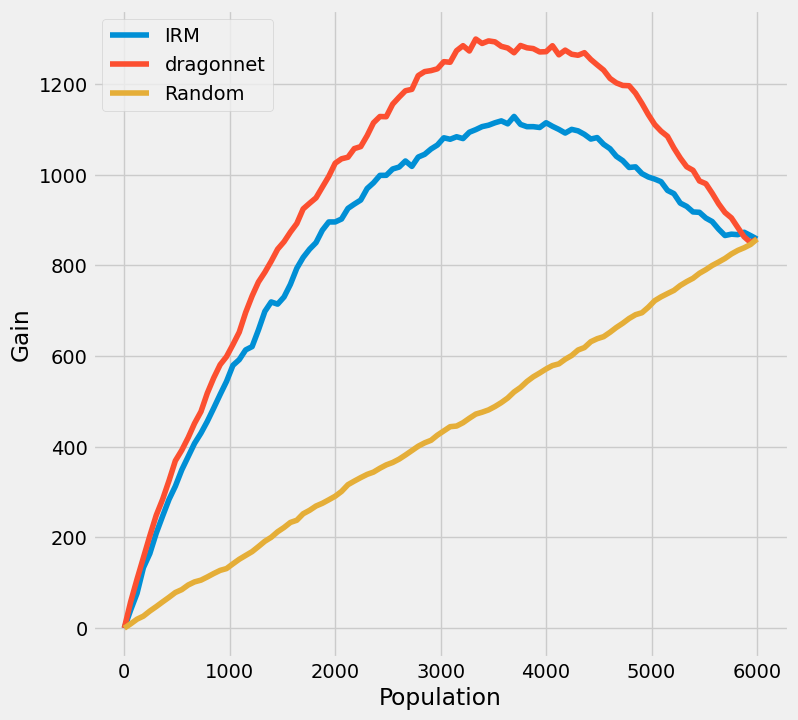

In [17]:
print(df_preds)
plt.rcParams['figure.figsize'] = 10.0, 7.5
plot_gain(df_preds)
plt.show()

# ATE compare 1

In [18]:
data_train=data_train.reset_index(drop=True)
dragonresult=df_preds.drop("IRM",axis=1)
draggonpred=pd.DataFrame(dragon.predict(X, treatment, y))
residdrag1=(data4_train["Death"]-draggonpred[1])*data4_train["Treat"]
residdrag0=(data4_train["Death"]-draggonpred[0])*(1-data4_train["Treat"])
RMSEdrag=sum((residdrag1+residdrag0)**2)/n
RMSEdrag=RMSEdrag**0.5
dragon_final_p=(draggonpred[1])*data4_train["Treat"]+(draggonpred[0])*(1-data4_train["Treat"])
loglossdrag=-sum(np.log(dragon_final_p*data4_train["Death"]+(1-dragon_final_p)*(1-data4_train["Death"])))/n
table_total={"training set":["ATE","pvalue","AUUC","RMSE_total","logloss","ite_bias"],
       "IRM":[c3_2[0],result3_2.pval[0],AUUCirm[0],result3_2_RMSE_final,result3_2_logloss_final,\
              np.sqrt((sum((pred3_2prob1["p"]-pred3_2prob0["p"]-data_train["true_ite.(Death)"])**2))/n)],
       "DragonNet":[dragon_ate,".",auuc_score(dragonresult)[0],RMSEdrag,loglossdrag,\
                    np.sqrt((sum((draggonpred[1]-draggonpred[0]-data_train["true_ite.(Death)"])**2))/n)]}
table_total=pd.DataFrame(table_total)
print(f"true ATE:{0.3016}")
table_total

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
true ATE:0.3016


,training set,IRM,DragonNet
0,ATE,2.857530e-01,0.264635
1,pvalue,2.904717e-140,.
2,AUUC,9.935987e-01,1.127515
3,RMSE_total,4.199537e-01,0.413223
4,logloss,5.283034e-01,0.514166
5,ite_bias,1.509780e-01,0.072253


# ATE compare 2 (trying)

In [19]:
term1=dragonresult["dragonnet"]
term2=data4_train["Treat"]/draggonpred[2]-(1-data4_train["Treat"])/(1-draggonpred[2])
term3=data4_train["Death"]-(data4_train["Treat"]*draggonpred[1]+(1-data4_train["Treat"])*draggonpred[0])
scorefunction=term1+term2*term3
phi=np.average(term1+term2*term3)
dgpvalue=np.sqrt((phi**2)/np.var(scorefunction)*n)
dgpvalue=1-scipy.stats.norm.cdf(dgpvalue)+scipy.stats.norm.cdf(-dgpvalue)
table_total={"training set":["ATE","pvalue","AUUC","RMSE_total","logloss","ite_bias"],
       "IRM":[c3_2[0],result3_2.pval[0],AUUCirm[0],result3_2_RMSE_final,result3_2_logloss_final,\
              np.sqrt((sum((pred3_2prob1["p"]-pred3_2prob0["p"]-data_train["true_ite.(Death)"])**2))/n)],
       "DragonNet":[phi,dgpvalue,auuc_score(dragonresult)[0],RMSEdrag,loglossdrag,\
                    np.sqrt((sum((draggonpred[1]-draggonpred[0]-data_train["true_ite.(Death)"])**2))/n)]}
table_total=pd.DataFrame(table_total)
print(f"true ATE:{0.3016}")
table_total

true ATE:0.3016


,training set,IRM,DragonNet
0,ATE,2.857530e-01,2.950813e-01
1,pvalue,2.904717e-140,5.111233e-164
2,AUUC,9.935987e-01,1.127515e+00
3,RMSE_total,4.199537e-01,4.132230e-01
4,logloss,5.283034e-01,5.141662e-01
5,ite_bias,1.509780e-01,7.225345e-02


# ---------------another results------------------

In [20]:
table_irm={"IRM":["logloss_g1","logloss_g0","logloss_m"],
           "value":[a3_2[0],aa3_2[0],b3_2[0]]}
table_irm=pd.DataFrame(table_irm)
print("training set")
table_irm

training set


,IRM,value
0,logloss_g1,0.524429
1,logloss_g0,0.531604
2,logloss_m,0.622676


In [21]:
loglossdrag1=dragon_final_p*data4_train["Death"]+(1-dragon_final_p)*(1-data4_train["Death"])
loglossdrag0=dragon_final_p*data4_train["Death"]+(1-dragon_final_p)*(1-data4_train["Death"])
loglossdrag1=-sum(np.log(loglossdrag1[data4_train["Treat"]==1]))/len(loglossdrag1[data4_train["Treat"]==1])
loglossdrag0=-sum(np.log(loglossdrag0[data4_train["Treat"]==0]))/len(loglossdrag0[data4_train["Treat"]==0])
table_dragon={"Dragon":["logloss_g1","logloss_g0","logloss_m"],
              "value":[loglossdrag1,\
                       loglossdrag0,\
                       log_loss(data4_train["Treat"],draggonpred[2])]}
table_dragon=pd.DataFrame(table_dragon)
print("training set")
table_dragon

training set


,Dragon,value
0,logloss_g1,0.501686
1,logloss_g0,0.524798
2,logloss_m,0.603418


# Propensity Score vs ITE (IRM)

In [22]:
pscore_irm=pd.DataFrame(np.array(residm3_2))
pscore_irm.columns=list("1")
pscore_irm["1"]=data3_train["Treat"]-pscore_irm["1"]
pscore_irm={"pscore":pscore_irm["1"],
            "ITE":df_preds["IRM"]}
pscore_irm=pd.DataFrame(pscore_irm)
pscore_irm=pscore_irm.sort_values(by="pscore")
pscore_irm["pscore"]=pscore_irm["pscore"]

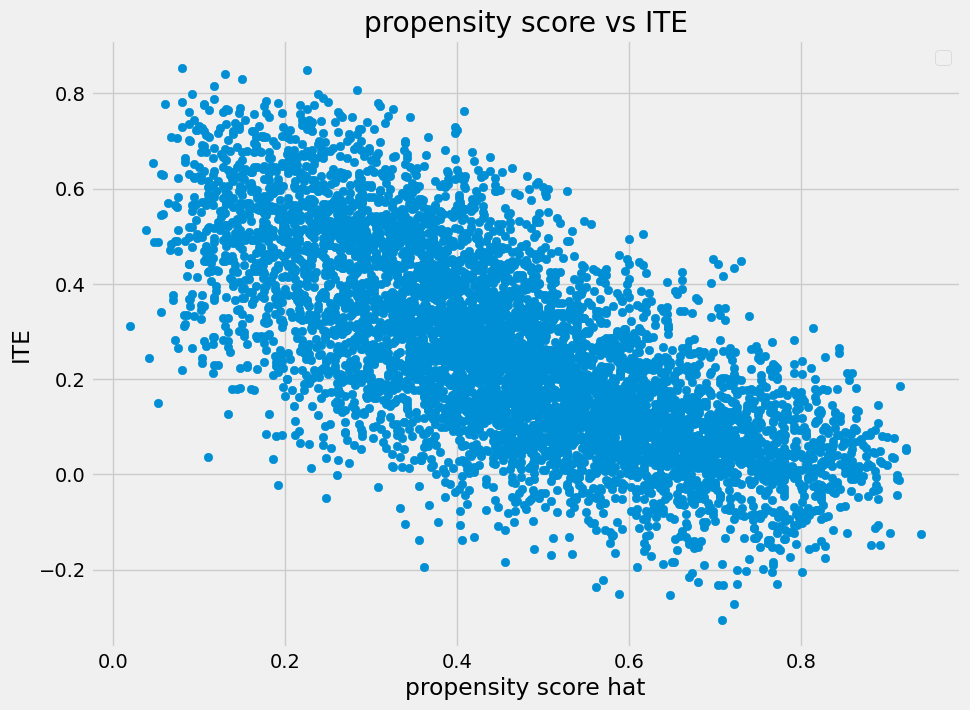

In [23]:
plt.legend()
plt.title('propensity score vs ITE')
plt.xlabel('propensity score hat')
_ =  plt.ylabel('ITE')
plt.scatter(pscore_irm["pscore"],pscore_irm["ITE"])
plt.show()

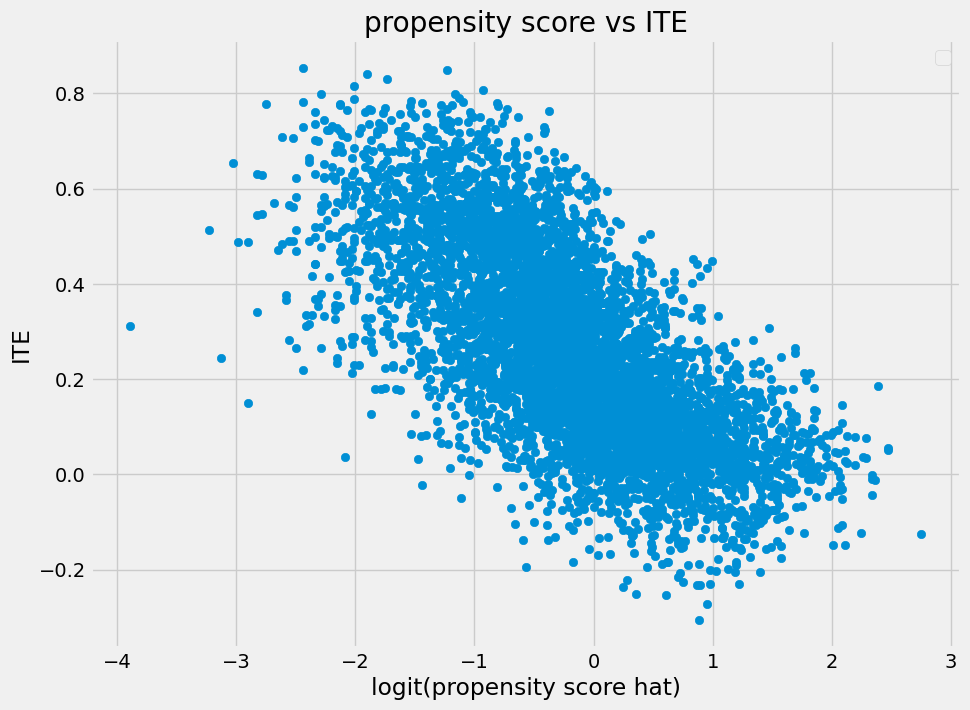

In [24]:
pscore_irm=pd.DataFrame(np.array(residm3_2))
pscore_irm.columns=list("1")
pscore_irm["1"]=data3_train["Treat"]-pscore_irm["1"]
pscore_irm={"pscore":pscore_irm["1"],
            "ITE":df_preds["IRM"]}
pscore_irm=pd.DataFrame(pscore_irm)
pscore_irm=pscore_irm.sort_values(by="pscore")
pscore_irm["pscore"]=np.log(pscore_irm["pscore"]/(1-pscore_irm["pscore"]))

plt.legend()
plt.title('propensity score vs ITE')
plt.xlabel('logit(propensity score hat)')
_ =  plt.ylabel('ITE')
plt.scatter(pscore_irm["pscore"],pscore_irm["ITE"])
plt.show()

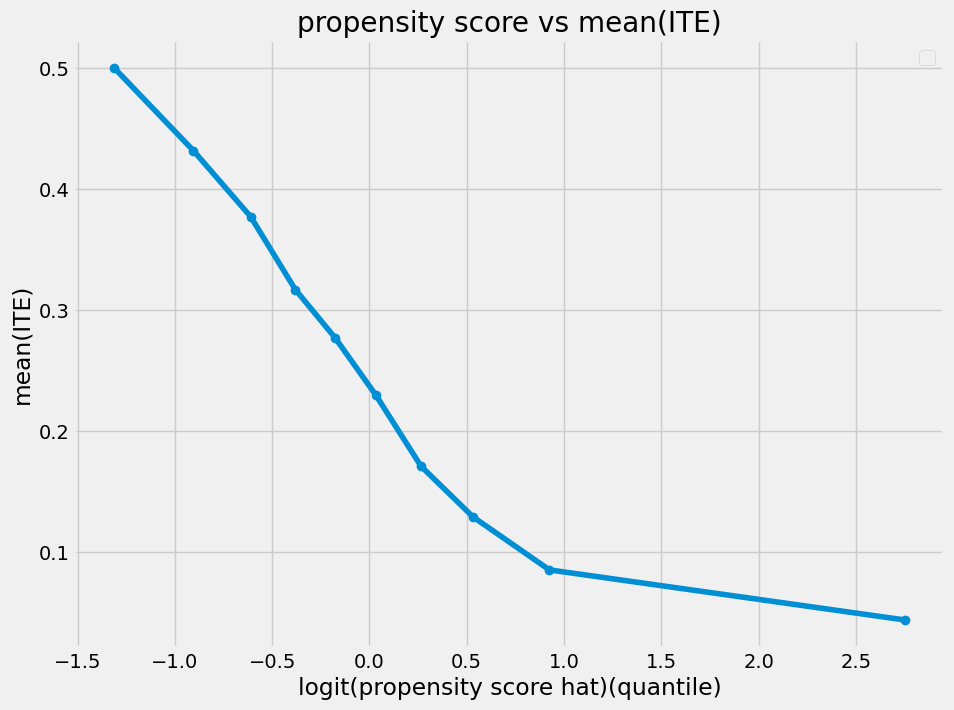

In [25]:
qt=[np.quantile(pscore_irm["pscore"],0),np.quantile(pscore_irm["pscore"],0.1),np.quantile(pscore_irm["pscore"],0.2),\
    np.quantile(pscore_irm["pscore"],0.3),np.quantile(pscore_irm["pscore"],0.4),np.quantile(pscore_irm["pscore"],0.5),\
    np.quantile(pscore_irm["pscore"],0.6),np.quantile(pscore_irm["pscore"],0.7),np.quantile(pscore_irm["pscore"],0.8),\
    np.quantile(pscore_irm["pscore"],0.9),np.quantile(pscore_irm["pscore"],1)]
gate=[0]*10
for i in range(10):
    subgroup=pscore_irm[pscore_irm["pscore"].between(qt[i],qt[i+1])]
    gate[i]=np.average(subgroup["ITE"])
plt.legend()
plt.title('propensity score vs mean(ITE)')
plt.xlabel('logit(propensity score hat)(quantile)')
_ =  plt.ylabel('mean(ITE)')
plt.plot(qt[1:11],gate,marker="o")
plt.show()

# CATE(propencity score)(95%CI may be wrong)

        0         1         2         3         4         5
0     1.0  0.000000  0.000000  0.000000  0.000000  0.000000
1     1.0  0.338339  0.037297  0.000000  0.000000  0.000000
2     1.0  0.376885  0.050002  0.000000  0.000000  0.000000
3     1.0  0.408529  0.063221  0.000000  0.000000  0.000000
4     1.0  0.422216  0.069959  0.000000  0.000000  0.000000
...   ...       ...       ...       ...       ...       ...
5995  1.0  0.000000  0.000000  0.021844  0.280631  0.697525
5996  1.0  0.000000  0.000000  0.019045  0.265066  0.715889
5997  1.0  0.000000  0.000000  0.011511  0.213469  0.775020
5998  1.0  0.000000  0.000000  0.011511  0.213469  0.775020
5999  1.0  0.000000  0.000000  0.000000  0.000000  1.000000

[6000 rows x 6 columns]
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t     P>|t|    [0.025    0.975]
0  0.531548  0.346393  1.534523  0.124954 -0.147507  1.210603
1 -0.432981  0.433245 -

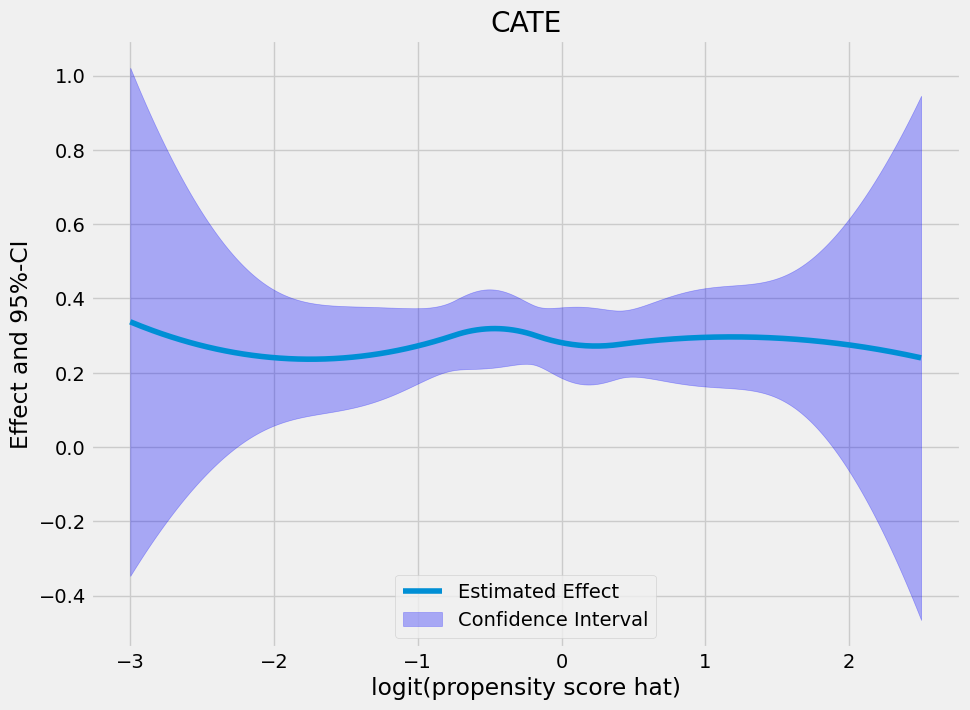

In [26]:
#try------------------------------------------------------------------------------------------------------------
design_matrix = patsy.dmatrix("bs(p, df=5, degree=2)", {"p": pscore_irm["pscore"]})
spline_basis = pd.DataFrame(design_matrix)
print(spline_basis)
cate = dml_irm_obj.cate(spline_basis)
print(cate)

new_data = {"p": np.linspace(-3, 2.5, 350)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
np.random.seed(1212)
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=5000)

#plot cate3-2
plt.rcParams['figure.figsize'] = 10.0, 7.5
df_cate['p'] = new_data['p']
fig, ax = plt.subplots()
ax.plot(df_cate['p'],df_cate['effect'], label='Estimated Effect')
ax.fill_between(df_cate['p'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('logit(propensity score hat)')
_ =  plt.ylabel('Effect and 95%-CI')
plt.show()